# River as a shapefile (raw format)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd

shapefile = gpd.read_file("edges.shp")
shapefile["rid"] = shapefile["rid"].astype(int)
shapefile.head()

,rid,netID,upDist,shreve,Length,addfunccol,geometry
0,1,1,1.000000,4.0,1.000000,1.00,"LINESTRING (0.00000 1.00000, 0.00000 0.00000)"
1,2,1,1.960106,1.0,0.960106,0.25,"LINESTRING (0.42592 1.86046, 0.00000 1.00000)"
2,3,1,1.980141,3.0,0.980141,0.75,"LINESTRING (0.16583 1.96601, 0.00000 1.00000)"
3,4,1,3.032648,1.0,1.052508,0.25,"LINESTRING (0.05008 3.01213, 0.16583 1.96601)"
4,5,1,3.072281,2.0,1.092141,0.50,"LINESTRING (0.75061 2.88840, 0.16583 1.96601)"


rid - unique identifier for river segment\
netID - river network ID, when dealing with multiple river outlets\
upDist - distance upstream from outlet (from the most upstream point on line)\
shreve - segment weighting based on Shreve's order\
addfunccol - additive function column, normalised shreve's order (used for weighting segments, a proxy for water volume)

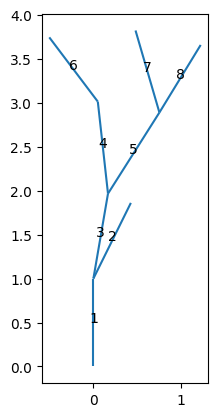

In [2]:
# edges (rid's)
ax = shapefile.plot()
shapefile.apply(
    lambda x: ax.annotate(text=x["rid"], xy=x.geometry.centroid.coords[0], ha="center"),
    axis=1,
)
plt.show()

In [3]:
# extract point information from shapely object: type(shapefile.geometry[0])
shapefile["points"] = shapefile.apply(lambda l: list(l["geometry"].coords), axis=1)
shapefile[["points_from", "points_to"]] = shapefile["points"].to_list()

# create a unique identifier for the start/end points of an edge
unique_locations = sorted(
    list(set([item for sublist in shapefile.points.to_list() for item in sublist]))
)
PID_GPT = {i: unique_locations[i] for i in range(len(unique_locations))}
GPT_PID = {v: k for k, v in PID_GPT.items()}

# map from geographic point, GPT, to unique node identifier, PID
shapefile["pid_from"] = shapefile["points_from"].apply(lambda x: GPT_PID[x])
shapefile["pid_to"] = shapefile["points_to"].apply(lambda x: GPT_PID[x])

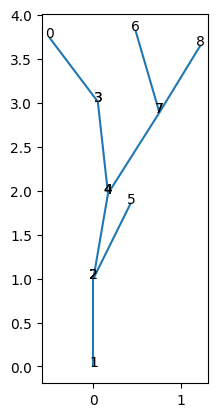

In [4]:
# node labels (pid's)
ax = shapefile.plot()
shapefile.apply(
    lambda x: ax.annotate(text=x["pid_from"], xy=x.points_from, ha="center"), axis=1
)
shapefile.apply(
    lambda x: ax.annotate(text=x["pid_to"], xy=x.points_to, ha="center"), axis=1
)
plt.show()

In [5]:
# neither of these functions are necessary, now I realise
def get_upstream_rids(row, df):
    upstream_rids = []
    up = df[df["pid_to"] == row["pid_from"]]

    while len(up) > 0:
        new_pids = list(up["pid_from"])
        upstream_rids.extend(up["rid"])
        up = df[df["pid_to"].isin(new_pids)]

    return upstream_rids


def calculate_on_left(df):
    grouped = df.groupby("pid_to")
    min_pid_from = grouped["pid_from"].transform("min")
    df["on_left"] = min_pid_from == df["pid_from"]
    return df

In [6]:
df = shapefile[
    ["rid", "upDist", "shreve", "Length", "addfunccol", "points", "pid_from", "pid_to"]
].copy()

df["upstream_rids"] = df.apply(lambda x: get_upstream_rids(x, df), axis=1)
df = calculate_on_left(df)

## River domain representation (continuous)

#### Mapping from segment to space

In [7]:
pid = 1  # the outlet node
df.loc[df["pid_to"] == pid, ["parent_x_offset"]] = 0
df.loc[df["pid_to"] == pid, ["parent_width"]] = 1

from_pids_line_up = []
finished = False

while not finished:
    # of length either 1 or 2
    if len(df[df["pid_from"] == pid]) > 0:
        df.loc[df["pid_to"] == pid, "parent_x_offset"] = float(
            df[df["pid_from"] == pid]["x_offset"].iloc[0]
        )
        df.loc[df["pid_to"] == pid, "parent_width"] = float(
            df[df["pid_from"] == pid]["width"].iloc[0]
        )

    layer = df[df["pid_to"] == pid].copy()
    layer["pct"] = layer["addfunccol"] / layer["addfunccol"].sum()
    from_pids = layer["pid_from"]

    if len(from_pids) == 0:
        finished = len(from_pids_line_up) == 0
        if not finished:
            pid = from_pids_line_up.pop(0)
        continue

    # add percentage share of addfunccol at each branching confluence
    df.loc[df["pid_from"].isin(from_pids), ["width"]] = (
        layer["parent_width"] * layer["pct"]
    )

    # for the branch on left, then right
    df.loc[df["pid_from"] == min(from_pids), ["x_offset"]] = layer["parent_x_offset"]

    if len(from_pids) == 2:
        df.loc[df["pid_from"] == max(from_pids), ["x_offset"]] = float(
            layer["parent_x_offset"].iloc[0]
        ) + float(df.loc[df["pid_from"] == min(from_pids), ["width"]].squeeze())

    # get next pid's
    from_pids_line_up.extend(list(from_pids))
    finished = len(from_pids_line_up) == 0
    pid = from_pids_line_up.pop(0)

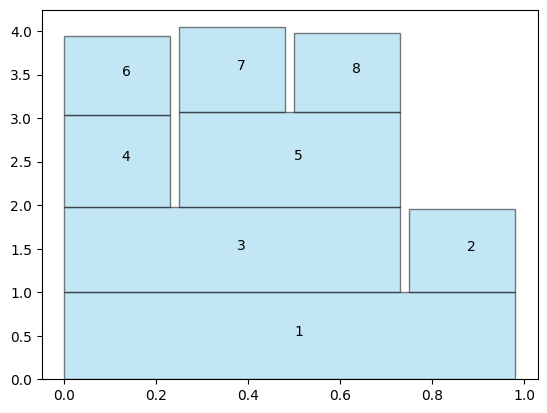

In [8]:
# plot bar
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

for i, row in df.iterrows():
    ax.bar(
        row["x_offset"],
        height=row["Length"],
        bottom=row["upDist"] - row["Length"],
        width=row["addfunccol"] - 0.02,  # epsilon
        align="edge",
        color="skyblue",
        alpha=0.5,
        edgecolor="black",
    )
    ax.annotate(
        row["rid"],
        xy=(
            row["x_offset"] + 0.5 * row["addfunccol"],
            row["upDist"] - 0.5 * row["Length"],
        ),
    )

plt.show()

##### River domain representation (as a shapely.Polygon object)

In [9]:
epsilon = 0.02
df["box_coord"] = [list() for i in range(len(df))]

for i, row in df.iterrows():
    x_left = row["x_offset"]
    x_right = row["x_offset"] + row["addfunccol"] - epsilon
    y_top = row["upDist"]
    y_bottom = row["upDist"] - row["Length"]

    df.loc[i, "box_coord"].extend(
        [
            (x_left, y_bottom),
            (x_left, y_top),
            (x_right, y_top),
            (x_right, y_bottom),
        ]
    )  # bottom-left, top-left, top-right, bottom-right (clockwise)

In [10]:
from itertools import groupby


def group_by_x(tuples):
    sorted_tuples = sorted(tuples, key=lambda point: point[0])
    groups = []

    for _, group in groupby(sorted_tuples, key=lambda point: point[0]):
        groups.append(list(group))

    return groups

In [11]:
all_points = sorted([item for sublist in df["box_coord"].values for item in sublist])
grouped_x = group_by_x(all_points)

new_list = []
for i, l in enumerate(grouped_x):
    if i % 2 == 0:
        new_list.append(l[0])
        new_list.append(l[-1])
    else:
        new_list.append(l[-1])
        new_list.append(l[0])

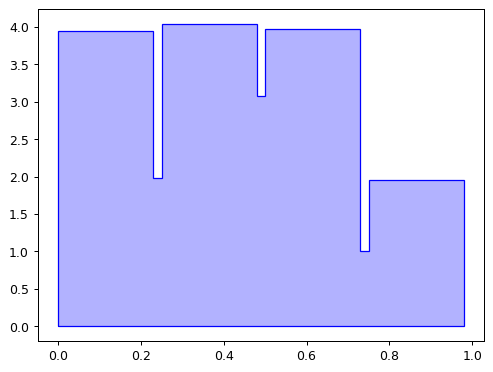

In [12]:
# create high-coverage continous domain representation
from shapely.geometry import Polygon
from shapely.plotting import plot_polygon, plot_points

fig = plt.figure(1, dpi=90)
ax = fig.add_subplot()
int = new_list + [new_list[0]]
polygon = Polygon(int)

plot_polygon(polygon, ax=ax, add_points=False, color="b")
plt.show()

In [13]:
# any shapely helper functions??? inside shape? distance?
polygon.bounds

(0.0, 0.0, 0.98, 4.044050746411085)

In [ ]:
# implement in pyro
# alpha and sigma_0, sigma_1 are constant (remove Xbeta, temporal) -> only v random (learn the function)


# 1. first get design
# 2. compute h_ij matrix given design
# 3. calculate covariance matrix for v, deterministic on h_ij
# 4. sample v, using same pyro syntax as latent variable
# 5. sample y given v with independent random noise (small, fixed) [mu=v, cov=Isigma]

# strip out all location finding latent variables, put in stream distance

# learning the design
# gradient (nudge back within polygon), baseline: batch bald - discretization of design space add points one at a time, approximation to optimal design (read paper)

# diagnostics, convergence

In [ ]:
# 18:41:39 From  Desi R. Ivanova  to  Everyone:
# 	BatchBALD
# 18:41:50 From  Adam  to  Everyone:
# 	https://arxiv.org/abs/1906.08158
# 18:48:50 From  Adam  to  Everyone:
# 	https://mlflow.org/docs/latest/index.html

# Model

Linear regression models that describe spatio-temporal dependence are generally formulated as:

$\bf y = \bf X \boldsymbol \beta + \bf v + \boldsymbol \epsilon$

where $\bf y$ is a stacked response vector of size $n \times 1$, with $n = S \times T$ (for $S$ spatial locations and $T$ timepoints), $\bf X$ is a $n \times p$ design matrix of $p$ covariates, $\boldsymbol \beta$ is a $p \times 1$ vector or regression coefficients, and $\bf v$ is a vector of spatio-temporal autocorrelated random effects.


\
Two main approaches are generally found to model spatio-temporal autocorrelation: 

(1) full covariance or descriptive models in which the space-time covariance function is constructed (i.e. Separable space-time VAR(1) model), and \
(2) dynamical model that involves the evolution of a spatial process (i.e. Vector autoregression spatial model)

In the second approach we just need to construct the spatial covariance matrix. Temporal dependence is incorporated in the error terms using a vector autoregression VAR(1). Edgar's paper showed that both approaches are equivalent, and the second approach is more computationally efficient.


#### Bayesian hierarchical model

$ p(\bf y_t | \bf y_{t-1}, \boldsymbol \theta, \bf X_t, \bf X_{t-1}, \boldsymbol \Phi_1, \Sigma) = \mathcal{N}(\boldsymbol \mu_t, \Sigma + \sigma_0^2 \bf I)$

$\boldsymbol \mu_t = \bf X_t \boldsymbol \beta + \boldsymbol \Phi_1(\bf y_{t-1} - \bf X_{t-1} \boldsymbol \beta)$

where

$\boldsymbol \Sigma = Cov(v_i)\ \forall i = 1,...,T$ is the $S \times S$ spatial covariance matrix, e.g., formulated by the exponential function with matrix entries of the form

$\boldsymbol \Sigma_{ij} := C(h_{ij} | \boldsymbol \theta) = \sigma_1^2 \exp(-h_{ij}/\alpha), \ \alpha > 0,\ h_{ij}$ is the stream distance between locations $s_i$ and $s_j$. Denote spatial covariance parameters by $\boldsymbol \theta = (\sigma_0^2,\sigma_1^2,\alpha)$.


$\boldsymbol \Phi_1$ is the $S \times S$ transition matrix determining the amount of temporal autocorrelation, e.g., in the simplest case, assuming the same temporal autocorrelation for all spatial locations, the diagonal elements of $\boldsymbol \Phi$ are all equal to $\phi$ and all the off-diagonal ones are set to zero,


$\boldsymbol \Phi_1 = 
\begin{bmatrix}
\phi & 0 & 0 & \cdots & 0 \\
0 & \phi & 0 & \cdots & 0 \\
0 & 0 & \phi & \cdots & 0 \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
0 & 0 & 0 & \cdots & \phi \\
\end{bmatrix}
$


##### Hyper priors

$\beta_1,...,\beta_p \sim \mathcal(0,10)$   # prior on the regression coefficients

$\sigma_0 \sim \text{Uniform}(0, 1) $ # prior on the nugget effect

$\sigma_1 \sim \text{Uniform}(0, 10) $ # prior partial sill parameters

$\alpha \sim \text{Uniform}(0, 16) $ # prior on spatial range parameters

$\phi \sim \text{Uniform}(-1,1) $ # prior on the autoregressive parameters, elements of $\boldsymbol \Phi_1$



\
See: https://www.fs.usda.gov/rm/pubs_journals/2022/rmrs_2022_santos_fernandes_e001.pdf


# Generator

In [14]:
from shapely.geometry import Point
import torch

# sample points in continuous domain


def random_sample_polygon(polygon, number):
    points = []
    minx, miny, maxx, maxy = polygon.bounds
    while len(points) < number:
        pnt = Point(np.random.uniform(minx, maxx), np.random.uniform(miny, maxy))
        if polygon.contains(pnt):
            points.append(pnt)
    return points

In [15]:
s_t = random_sample_polygon(polygon, 3)
s_t

[<POINT (0.373 1.484)>, <POINT (0.299 0.01)>, <POINT (0.018 2.736)>]

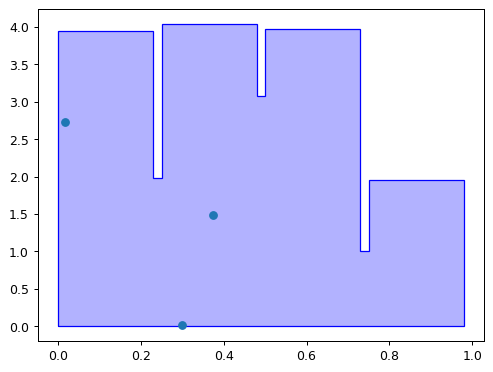

In [16]:
fig = plt.figure(1, dpi=90)
ax = fig.add_subplot()

plot_polygon(polygon, ax=ax, add_points=False, color="b")
xs = [point.x for point in s_t]
ys = [point.y for point in s_t]
plt.scatter(xs, ys)
plt.show()

In [17]:
import scipy

# calculate stream distance
h_ij = scipy.spatial.distance_matrix([(0, y) for y in ys], [(0, y) for y in ys])
h_ij

# fix h_ij so that goes around finger
# small kernel term that involves x coordinate -> effect of being a gradient term that encouages

array([[0.        , 1.47373594, 1.2522123 ],
       [1.47373594, 0.        , 2.72594824],
       [1.2522123 , 2.72594824, 0.        ]])

In [43]:
# MAP from continuous domain to geospaital xy coords


def xy_along_segment(s_i, df):
    # get corresponding segment of s_i from df
    idx_df = [i for i in range(len(df)) if s_i.within(Polygon(df["box_coord"].iloc[i]))]
    row = df.iloc[idx_df].squeeze()

    # get line start and end points on geographic space
    x1, y1 = row["points"][0]
    x2, y2 = row["points"][1]

    # Calculate the differences in x and y coordinates
    dx = x2 - x1
    dy = y2 - y1

    # Calculate the fraction of the total distance
    dist_along_segment = row["upDist"] - s_i.y
    fraction = dist_along_segment / row["Length"]

    # Calculate the coordinates of the point along the line
    x = x1 + fraction * dx
    y = y1 + fraction * dy

    return (x, y)

In [44]:
geo_coords = [xy_along_segment(s_i, df) for s_i in s_t]
geo_coords

[(0.0818517874995771, 1.47680649077019),
 (0.0, 0.010045151573481959),
 (0.08270365349482961, 2.7172777556029613)]

In [255]:
def xy_segment_info(s_i, df):
    # get corresponding segment of s_i from df
    idx_df = [i for i in range(len(df)) if s_i.within(Polygon(df["box_coord"].iloc[i]))]
    row = df.iloc[idx_df].squeeze()

    # Calculate the fraction of the total distance
    dist_along_segment = row["upDist"] - s_i.y

    return {
        "pid_from": row["pid_from"],
        "pid_to": row["pid_to"],
        "dist_along_segment": dist_along_segment,
        "length": row["Length"],
    }

In [256]:
si_info = [xy_segment_info(s_i, df) for s_i in s_t]
si_info

[{'pid_from': 4,
  'pid_to': 2,
  'dist_along_segment': 0.49635960418034575,
  'length': 0.980140695953742},
 {'pid_from': 2,
  'pid_to': 1,
  'dist_along_segment': 0.989954848426518,
  'length': 1.0},
 {'pid_from': 3,
  'pid_to': 4,
  'dist_along_segment': 0.2966548873453343,
  'length': 1.052507581049577}]

In [259]:
h_ij

array([[0.        , 1.47373594, 1.2522123 ],
       [1.47373594, 0.        , 2.72594824],
       [1.2522123 , 2.72594824, 0.        ]])

In [ ]:
import networkx as nx


# encode as networkx object and plot
G = nx.Graph()
G.add_weighted_edges_from(
    list(zip(shapefile.pid_from, shapefile.pid_to, shapefile.Length))
)
nx.shortest_path_length(G, source=0, weight="weight")

In [ ]:
# encode as networkx object and plot
DiG = nx.DiGraph()
DiG.add_weighted_edges_from(
    list(zip(shapefile.pid_from, shapefile.pid_to, shapefile.Length))
)
nx.shortest_path_length(DiG, source=0, weight="weight")

{0: 0,
 3: 0.915953405248001,
 4: 1.968460986297578,
 2: 2.94860168225132,
 1: 3.94860168225132}

In [ ]:
def is_flow_connected_directed(pid_from_1, pid_from_2):
    try:
        nx.shortest_path_length(
            DiG, source=pid_from_1, target=pid_from_2, weight="weight"
        )
        return True
    except nx.NetworkXNoPath:
        return False


def is_flow_connected(pid_from_1, pid_from_2):
    return any(
        [
            is_flow_connected_directed(pid_from_1, pid_from_2),
            is_flow_connected_directed(pid_from_2, pid_from_1),
        ]
    )

In [ ]:
point_1_idx = 2
point_2_idx = 0

# first s_i point, get pid_to (most downstream)
pid_from_1 = si_info[point_1_idx]["pid_from"]
pid_to_1 = si_info[point_1_idx]["pid_to"]

# second_i point, get pid_from (most upstream)
pid_from_2 = si_info[point_2_idx]["pid_from"]

if is_flow_connected(pid_from_1, pid_from_2):  ### FIXME get most upstream point
    # get in_between_dist
    in_between_dict = nx.shortest_path_length(DiG, source=pid_to_1, weight="weight")

    # if not flow connected, return zero
    if pid_from_2 not in in_between_dict.keys():
        pass

    in_between_dist = in_between_dict[pid_from_2]

    # first s_i point, calculate distance from pid_to (most downstream) to the point
    dist_bottom_to_pt_1 = (
        si_info[point_1_idx]["length"] - si_info[point_1_idx]["dist_along_segment"]
    )

    # second s_i point, calculate distance from pid_from (most upstrem) to the point
    dist_top_to_pt_2 = si_info[point_2_idx]["dist_along_segment"]

    stream_dist = in_between_dist + dist_bottom_to_pt_1 + dist_top_to_pt_2

    # make symmetric dist

#### OTHERWISE, use non directed graph and take away different distances


stream_dist

1.2522122978845884

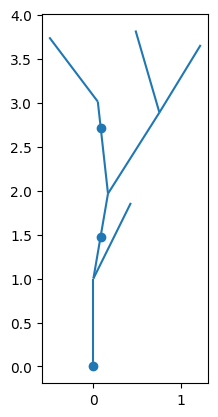

In [45]:
ax = shapefile.plot()
plt.scatter([i[0] for i in geo_coords], [i[1] for i in geo_coords])
plt.show()

In [116]:
from gstools import SRF, Gaussian

# get bounding box for geographic space
flatten_tuples = [t for tuples_list in df["points"] for t in tuples_list]
x_values, y_values = zip(*flatten_tuples)

# create reference covariates
model = Gaussian(dim=2, var=1, len_scale=1)
srf = SRF(model, seed=10)

x_field = np.arange(min(x_values), max(x_values), 0.01)
y_field = np.arange(min(y_values), max(y_values), 0.01)

field = srf.structured([x_field, y_field])

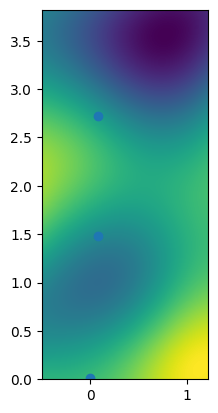

In [117]:
fig, ax = plt.subplots()
ax.imshow(
    field.T,
    origin="lower",
    extent=(min(x_values), max(x_values), min(y_values), max(y_values)),
)
plt.scatter([i[0] for i in geo_coords], [i[1] for i in geo_coords])
plt.show()

In [167]:
# implement model -- set parameters
T = 10
S = 3
p = 1

params = {
    "beta_0": 2.0,
    "beta_1": 1.0,
    "sigma_0": 0.02,
    "sigma_1": 0.25,
    "alpha": 1.75,
    "phi": 0.5,
}

In [195]:
# sample from covariate values
covariates = np.array([float(srf.structured([x, y]).squeeze()) for x, y in geo_coords])
covariates

array([-0.6169303 ,  0.31363873, -0.26148306])

In [196]:
X_1 = torch.stack([torch.tensor(np.ones(S)), torch.tensor(covariates)]).t().float()
X_1

tensor([[ 1.0000, -0.6169],
        [ 1.0000,  0.3136],
        [ 1.0000, -0.2615]])

In [202]:
beta = torch.tensor([params["beta_0"], params["beta_1"]])
beta

tensor([2., 1.])

In [203]:
# mean response
X_t_beta = torch.matmul(X_1, beta)
X_t_beta

tensor([1.3831, 2.3136, 1.7385])

In [198]:
# zero mean random variable, spatially dependent
SIGMA = (params["sigma_1"] ** 2) * np.exp(-h_ij / params["alpha"])
SIGMA = torch.tensor(SIGMA)
SIGMA

tensor([[0.0625, 0.0269, 0.0306],
        [0.0269, 0.0625, 0.0132],
        [0.0306, 0.0132, 0.0625]], dtype=torch.float64)

In [207]:
# independent noise
cov = torch.tensor((params["sigma_0"] ** 2) * np.identity(S)) + SIGMA

In [211]:
from torch.distributions.multivariate_normal import MultivariateNormal

distrib = MultivariateNormal(loc=X_t_beta, covariance_matrix=cov.float())
y1 = distrib.rsample()
y1

tensor([1.4295, 2.1354, 1.4860])

In [217]:
# transition matrix
PHI = torch.tensor(params["phi"] * np.identity(S)).float()
PHI

tensor([[0.5000, 0.0000, 0.0000],
        [0.0000, 0.5000, 0.0000],
        [0.0000, 0.0000, 0.5000]])

In [226]:
y_t_minus_1 = y1
X_t_minus_1_beta = X_t_beta  # assume fixed for all t, in this example

y = y1

for t in range(1, T):
    mu_t = X_t_beta + torch.matmul(PHI, y_t_minus_1 - X_t_minus_1_beta)
    distrib = MultivariateNormal(loc=mu_t, covariance_matrix=cov.float())
    y_t = distrib.rsample()

    y = torch.concat([y, y_t])
    y_t_minus_1 = y_t

In [227]:
y

tensor([1.1344, 2.2652, 1.2914, 1.7141, 2.4238, 2.2781, 1.3430, 2.1860, 2.1145,
        1.7693, 2.5683, 2.1675, 1.2174, 2.0566, 1.8388, 1.2711, 2.3781, 1.5542,
        1.3536, 2.4000, 1.9223, 1.7035, 2.3589, 2.0143, 1.2242, 2.3603, 1.4980,
        1.0990, 2.5295, 1.5559])

<Axes: >

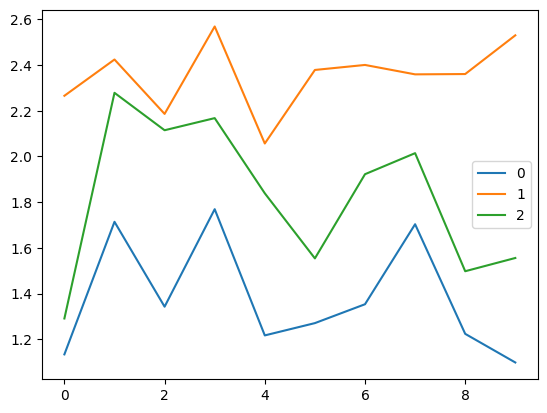

In [238]:
pd.DataFrame(y.reshape(T, S).numpy()).plot()

In [ ]:
# how to implement this in codebase

# just Gaussian process based on stream distance (spatial)

# we have generative model, need likelihood (pyro? -> have a way to test it. In pure python, write down likelihood. Compare same data)


# pyro -> once the generator is written, pyro gives likelihood for free

# likelihood is the factorised Gaussian, uncorrelated errors

In [ ]:
# stochastic volatility, environmental variables exhibit this. high-variability/low-variability -> maybe a generalisation
# first and second order differencing (michael stein, slides) -> references

## River as graph (NetworkX)

C:\Users\n10907700\AppData\Local\Temp\ipykernel_11216\1569939559.py:11: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(


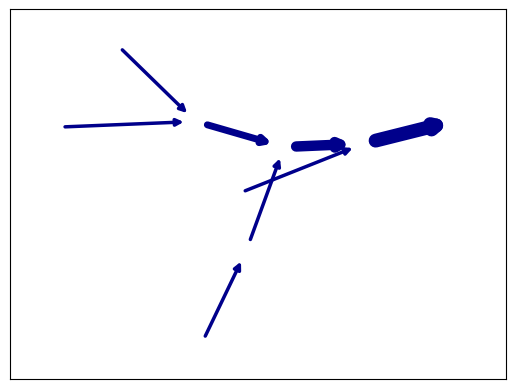

In [118]:
import networkx as nx

# encode as networkx object and plot
G = nx.DiGraph()
G.add_weighted_edges_from(
    list(zip(shapefile.pid_from, shapefile.pid_to, shapefile.addfunccol * 10))
)
# adding edges in the form: G.add_weighted_edges_from([(1, 2, 0.5), (3, 1, 1.75)])
pos = nx.spring_layout(G)
widths = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edges(
    G,
    pos,
    edgelist=widths.keys(),
    width=list(widths.values()),
    edge_color="darkblue",
    alpha=1,
)
plt.show()
# nodelist = G.nodes()
# nx.draw_networkx_nodes(G,pos,
#                        nodelist=nodelist,
#                        node_size=1500,
#                        node_color='black',
#                        alpha=0.7)
# nx.draw_networkx_labels(G, pos=pos,
#                         labels=dict(zip(nodelist,nodelist)),
#                         font_color='white')